In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras import models, layers
from PerformanceAnalysis import PerformanceAnalysis
from Visualization import Visualization
from DatasetFromDisk import DatasetFromDisk
import json
import os

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Setup

In [2]:
config_file = open('config.json')
config_vars = json.load(config_file)
config_file.close()

logs_dir = config_vars["logs_dir"] + "\\brainTumor"

if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)

In [3]:
config_file = open('visual_config.json')
config_vars = json.load(config_file)
config_file.close()

shap_colors_neg = config_vars["shap_colors"]["negative"]
shap_colors_pos = config_vars["shap_colors"]["positive"]
shap_colors = np.array([tuple(shap_colors_neg), tuple(shap_colors_pos)])

title_size = config_vars["title_font_size"]
label_size = config_vars["labels_font_size"]

green_color = tuple([x/255 for x in config_vars["green_colors"]["c2"]])

In [8]:
height = 256
width = 256
channels = 3
image_shape = (height, width, channels)
colormap = cv2.COLORMAP_VIRIDIS
data_disk = DatasetFromDisk(height, width, channels, colormap)

In [9]:
# Create the objects to perform performance analysis and visualization
perf_analysis = PerformanceAnalysis()
visual = Visualization()

## Prepare image paths

In [10]:
dataset_folder = ".\\datasets\\brain_tumor"

train_folders = [f"{dataset_folder}\\images\\train\\1", f"{dataset_folder}\\images\\train\\2", f"{dataset_folder}\\images\\train\\3"]

test_folders = [f"{dataset_folder}\\images\\test\\1", f"{dataset_folder}\\images\\test\\2", f"{dataset_folder}\\images\\test\\3"]

train_paths = []
train_labels = []

test_paths = []
test_labels = []

cont = 1

for folder in train_folders:
    paths = os.listdir(folder)
    for path in paths:
        train_paths.append(f"{folder}\\{path}")
        train_labels.append(cont)
    cont += 1
    
cont = 1

for folder in test_folders:
    paths = os.listdir(folder)
    for path in paths:
        test_paths.append(f"{folder}\\{path}")
        test_labels.append(cont)
    cont += 1

## Create dataset object

### Train

In [11]:
batch_size = 32

rand_gen = np.random.default_rng(seed=42)

p = rand_gen.permutation(len(train_paths))
train_paths_rand = np.array(train_paths)[p]
train_labels_rand = np.array(train_labels)[p] - 1

train_dataset = tf.data.Dataset.from_tensor_slices((train_paths_rand, train_labels_rand))
train_dataset = train_dataset.map(lambda x, y: data_disk.process_path(x, y), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)

### Test

In [12]:
p = rand_gen.permutation(len(test_paths))
test_paths_rand = np.array(test_paths)[p]
test_labels_rand = np.array(test_labels)[p] - 1

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths_rand, test_labels_rand))
test_dataset = test_dataset.map(lambda x, y: data_disk.process_path(x, y), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)

### Get examples of the dataset

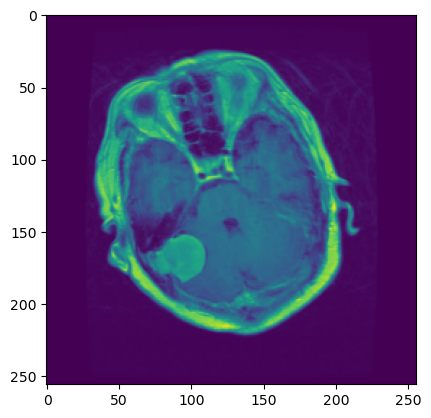

In [13]:
for i, label in train_dataset.take(2):
    plt.imshow(i[0].numpy())
    plt.show()

## Prepare examples to extract explanations

In [14]:
class_0_exp = test_folders[0] + "\\" + rand_gen.choice(os.listdir(test_folders[0]), size=1)[0]
class_1_exp = test_folders[1] + "\\" + rand_gen.choice(os.listdir(test_folders[1]), size=1)[0]
class_2_exp = test_folders[2] + "\\" + rand_gen.choice(os.listdir(test_folders[2]), size=1)[0]

exp_examples_paths = [class_0_exp, class_1_exp, class_2_exp]
exp_mask_paths = [i.replace("images", "masks") for i in exp_examples_paths]

exp_mask_paths = [f"{i[:-5]}_mask.tiff" for i in exp_mask_paths]

In [15]:
exp_examples_paths, exp_mask_paths

(['.\\datasets\\brain_tumor\\images\\test\\1\\f603.tiff',
  '.\\datasets\\brain_tumor\\images\\test\\2\\f2326.tiff',
  '.\\datasets\\brain_tumor\\images\\test\\3\\f1069.tiff'],
 ['.\\datasets\\brain_tumor\\masks\\test\\1\\f603_mask.tiff',
  '.\\datasets\\brain_tumor\\masks\\test\\2\\f2326_mask.tiff',
  '.\\datasets\\brain_tumor\\masks\\test\\3\\f1069_mask.tiff'])

In [17]:
images_to_explain, true_masks = data_disk.process_images_and_masks(exp_examples_paths, exp_mask_paths)

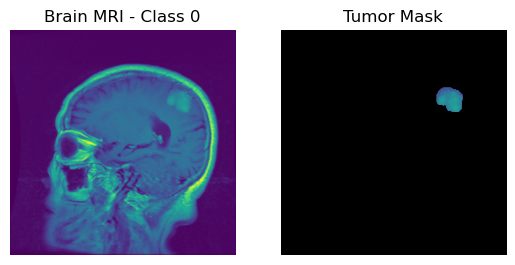

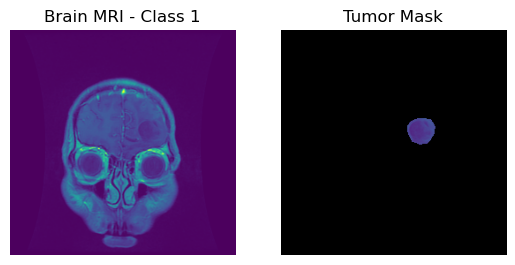

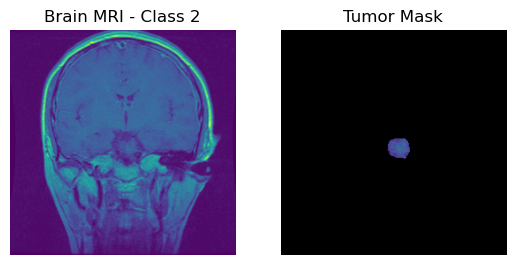

In [18]:
for i in range(len(images_to_explain)):
    plt.subplot(1,2,1)
    plt.imshow(images_to_explain[i])
    plt.title(f"Brain MRI - Class {i}")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(true_masks[i])
    plt.title("Tumor Mask")
    plt.axis("off")
    
    plt.show()

## Create Raw Convolutional Neural Network (CNN)

In [23]:
# Define the input shape
inputs = layers.Input(shape=image_shape)

# Add convolutional layers and pooling layers
x = layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((3, 3))(x)

x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((3, 3))(x)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten the output of the last convolutional layer
x = layers.Flatten()(x)

# Add dense layers
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(3, activation='softmax')(x)

# Create the model
cnn_raw = models.Model(inputs=inputs, outputs=outputs)

In [24]:
opt = keras.optimizers.Nadam(learning_rate=0.005, beta_1=0.9,
beta_2=0.99)

cnn_raw.compile(loss="sparse_categorical_crossentropy",
optimizer=opt, metrics=["accuracy"])

In [25]:
cnn_raw.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 252, 252, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 84, 84, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 82, 82, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 80, 80, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 885,395 (3.38 MB)

 Trainable params: 885,395 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history_multi1 = cnn_raw.fit(train_dataset, epochs=10)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 69s 819ms/step - accuracy: 0.4590 - loss: 14.8371
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 64s 823ms/step - accuracy: 0.6787 - loss: 0.7217
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 71s 914ms/step - accuracy: 0.6889 - loss: 0.6806
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 75s 956ms/step - accuracy: 0.6961 - loss: 0.6764
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 73s 938ms/step - accuracy: 0.7126 - loss: 0.6128
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 71s 914ms/step - accuracy: 0.6984 - loss: 0.6501
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 70s 896ms/step - accuracy: 0.7468 - loss: 0.5618
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 66s 847ms/step - accuracy: 0.7614 - loss: 0.5168
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 63s 810ms/step - accuracy: 0.7571 - loss: 0.5366
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 64s 817ms/step - accuracy: 0.7981 - loss: 0.4481


(0.0, 10.0, 0.0, 1.0)

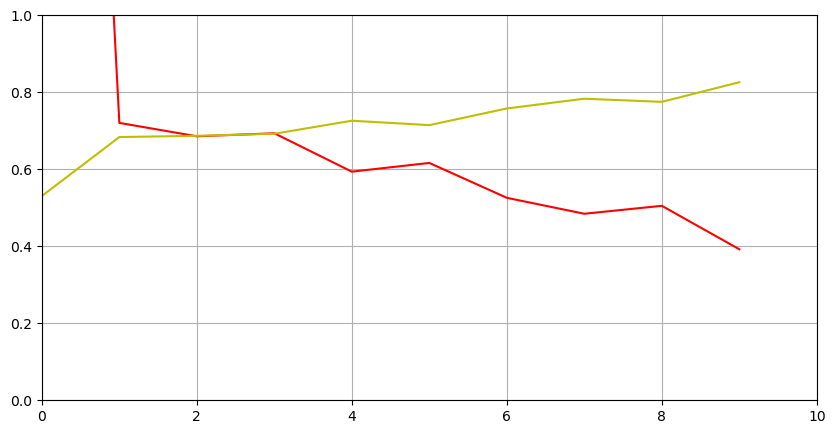

In [27]:
h=history_multi1.history
plt.figure(figsize=(10,5))
plt.plot(h['loss'], "r")
plt.plot(h['accuracy'], "y")
plt.grid(True)
plt.axis([0,10,0,1])

In [28]:
# Predict on the entire test dataset
all_predictions = []
all_labels = []

for images, labels in test_dataset:
    predictions = cnn_raw.predict(images, verbose=0)
    all_predictions.append(predictions)
    all_labels.append(labels)

all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

predicted_classes = np.argmax(all_predictions, axis=1)

In [29]:
cnn_raw_acc = 1 - np.sum(predicted_classes != all_labels)/len(test_labels)
print(f"Accuracy: {cnn_raw_acc}")

Accuracy: 0.8224755700325733


In [30]:
cnn_raw_cm = confusion_matrix(all_labels, predicted_classes)

Classes          0
0         0.528169
1         0.877622
2         0.962366
Average   0.789386
Accuracy  0.822476

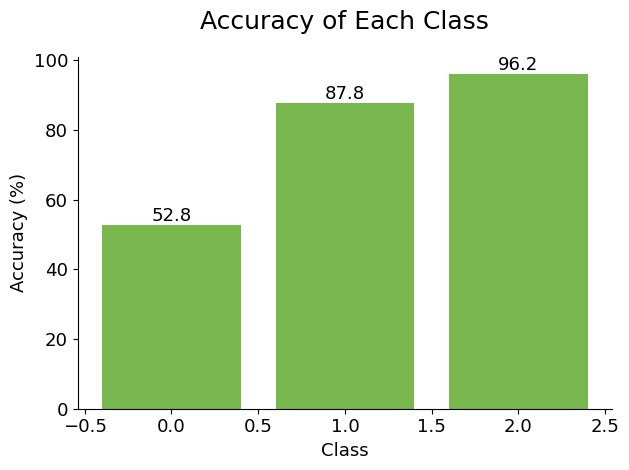

In [31]:
cnn_raw_pd_accs = perf_analysis.acc_for_class(cnn_raw_cm, figure=True, colors=green_color)
cnn_raw_pd_accs.loc[4] = cnn_raw_acc
cnn_raw_pd_accs = cnn_raw_pd_accs.rename(index={4: "Accuracy"})
cnn_raw_pd_accs

### Extract Explanations

Pred Index: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:11, 11.66s/it]               


Pred Index: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:11, 11.16s/it]               


Pred Index: 2


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:12, 12.43s/it]               


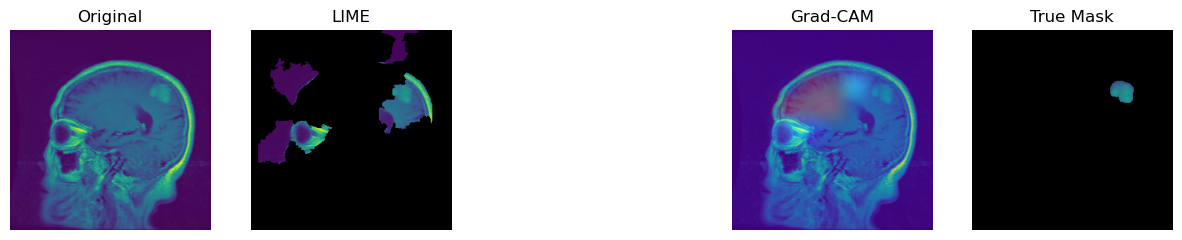

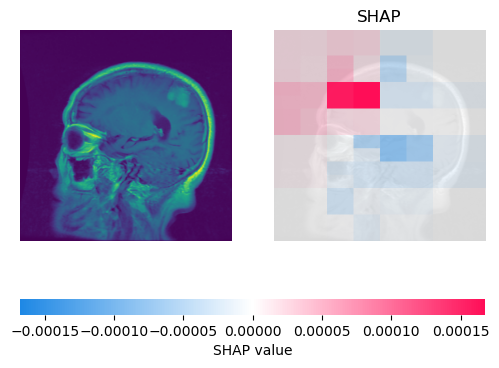

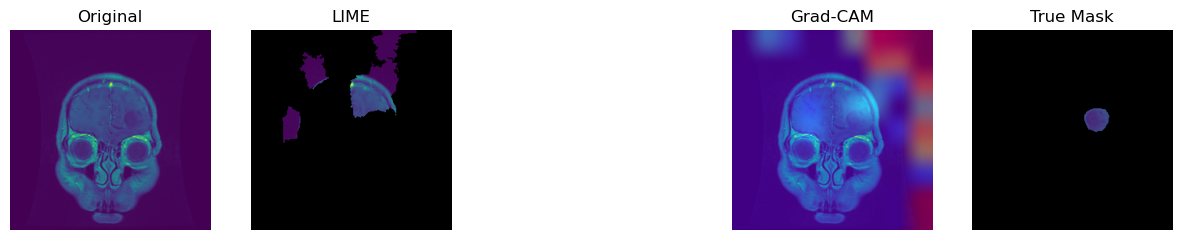

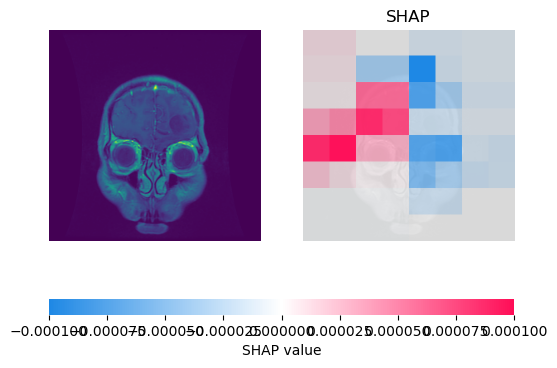

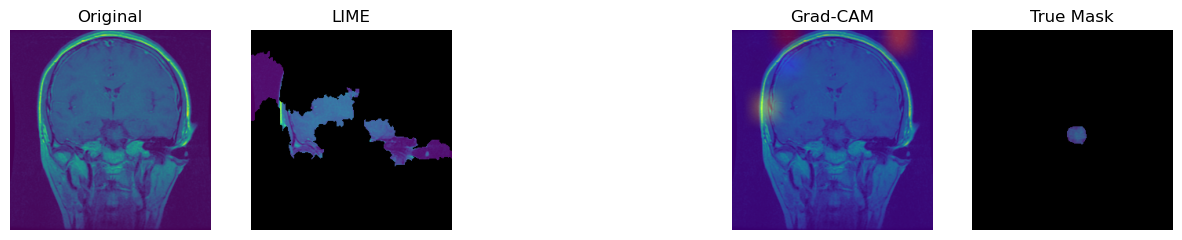

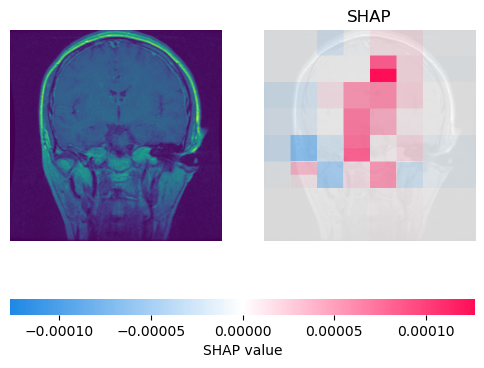

In [152]:
last_conv_layer_name = cnn_raw.layers[-6].name

visual.brain_tumor(images_to_explain, true_masks, cnn_raw, last_conv_layer_name, f"{logs_dir}\\cnn_raw")

## Create CNN by Transfer Learning with VGG16

In [153]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=image_shape)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(3, activation='softmax')(x)

# Create the new model
tl_vgg = models.Model(inputs=base_model.input, outputs=predictions)

In [154]:
optv2 = keras.optimizers.Nadam(learning_rate=0.005, beta_1=0.9,
beta_2=0.99)

tl_vgg.compile(loss="sparse_categorical_crossentropy",
optimizer=optv2, metrics=["accuracy"])

In [155]:
tl_vgg.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,883 (57.14 MB)

 Trainable params: 264,195 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [156]:
history_multi2 = tl_vgg.fit(train_dataset, epochs=10)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 364s 5s/step - accuracy: 0.6593 - loss: 3.6731
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 361s 5s/step - accuracy: 0.8876 - loss: 0.2754
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 360s 5s/step - accuracy: 0.9244 - loss: 0.2126
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 362s 5s/step - accuracy: 0.9328 - loss: 0.1801
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 360s 5s/step - accuracy: 0.9463 - loss: 0.1544
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 361s 5s/step - accuracy: 0.9436 - loss: 0.1441
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 361s 5s/step - accuracy: 0.9345 - loss: 0.1627
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 360s 5s/step - accuracy: 0.9515 - loss: 0.1346
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 363s 5s/step - accuracy: 0.9633 - loss: 0.0930
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 361s 5s/step - accuracy: 0.9648 - loss: 0.0863


(0.0, 10.0, 0.0, 1.0)

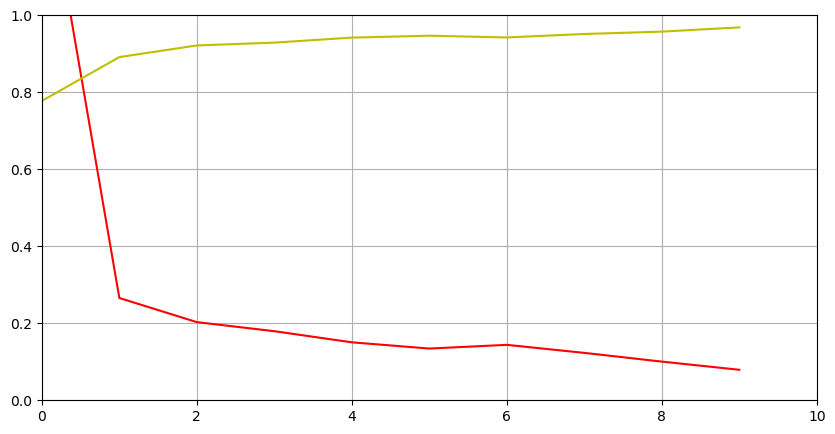

In [157]:
h=history_multi2.history
plt.figure(figsize=(10,5))
plt.plot(h['loss'], "r")
plt.plot(h['accuracy'], "y")
plt.grid(True)
plt.axis([0,10,0,1])

In [158]:
# Predict on the entire test dataset
all_predictions = []
all_labels = []

for images, labels in test_dataset:
    predictions = tl_vgg.predict(images, verbose=0)
    all_predictions.append(predictions)
    all_labels.append(labels)

all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

predicted_classes = np.argmax(all_predictions, axis=1)

In [159]:
tl_vgg_acc = 1 - np.sum(predicted_classes != all_labels)/len(test_labels)
print(f"Accuracy: {tl_vgg_acc}")

Accuracy: 0.9071661237785016


In [160]:
tl_vgg_cm = confusion_matrix(all_labels, predicted_classes)

Classes          0
0         0.760563
1         0.926573
2         0.989247
Average   0.892128
Accuracy  0.907166

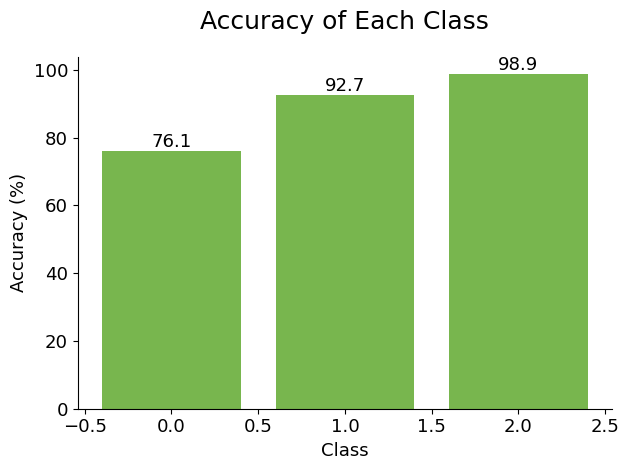

In [161]:
tl_vgg_pd_accs = perf_analysis.acc_for_class(tl_vgg_cm, figure=True, colors=green_color)
tl_vgg_pd_accs.loc[4] = tl_vgg_acc
tl_vgg_pd_accs = tl_vgg_pd_accs.rename(index={4: "Accuracy"})
tl_vgg_pd_accs

### Extract Explanations

Pred Index: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:52, 52.52s/it]               


Pred Index: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:53, 53.75s/it]               


Pred Index: 2


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:50, 50.84s/it]               


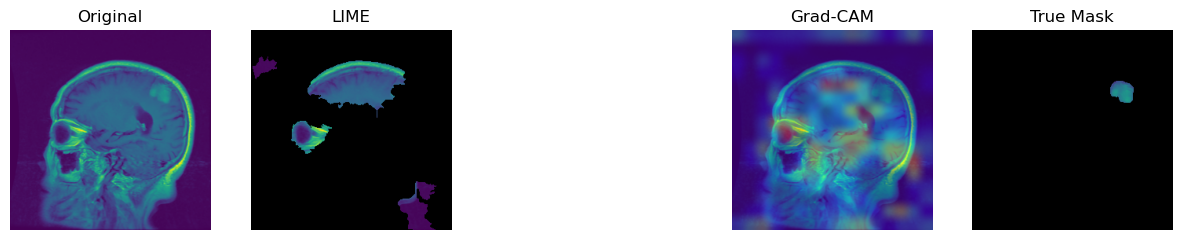

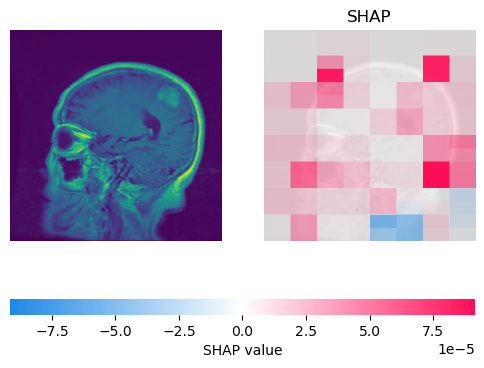

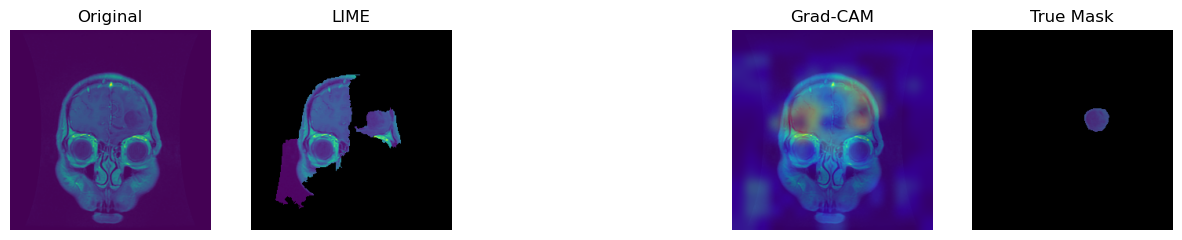

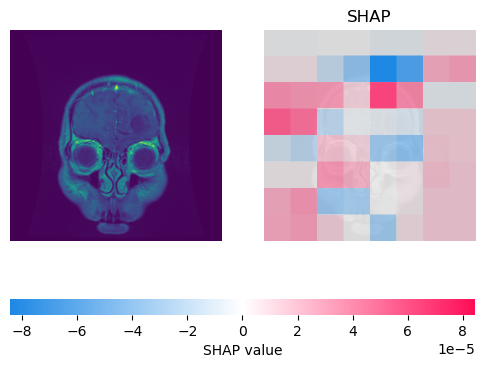

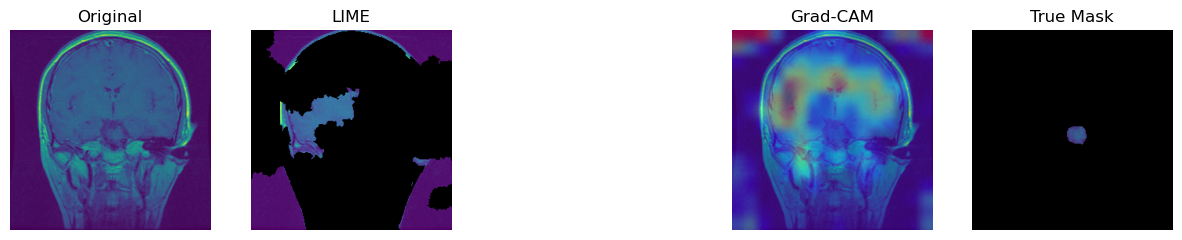

In [162]:
last_conv_layer_name = "block5_conv3"

visual.brain_tumor(images_to_explain, true_masks, tl_vgg, last_conv_layer_name, f"{logs_dir}\\vgg")

## Create CNN by Transfer Learning with MobileNetV2

In [163]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_shape)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(3, activation='softmax')(x)

# Create the new model
tl_mn = models.Model(inputs=base_model.input, outputs=predictions)

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


In [164]:
optv3 = keras.optimizers.Nadam(learning_rate=0.005, beta_1=0.9,
beta_2=0.99)

tl_mn.compile(loss="sparse_categorical_crossentropy",
optimizer=optv3, metrics=["accuracy"])

In [165]:
tl_mn.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,915,395 (11.12 MB)

 Trainable params: 657,411 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [166]:
history_multi3 = tl_mn.fit(train_dataset, epochs=10)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.6166 - loss: 1.9564
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.8338 - loss: 0.3848
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.8714 - loss: 0.3048
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.8943 - loss: 0.2522
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9156 - loss: 0.2126
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9260 - loss: 0.1863
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9346 - loss: 0.1601
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9460 - loss: 0.1460
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9512 - loss: 0.1261
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9440 - loss: 0.1359


(0.0, 10.0, 0.0, 1.0)

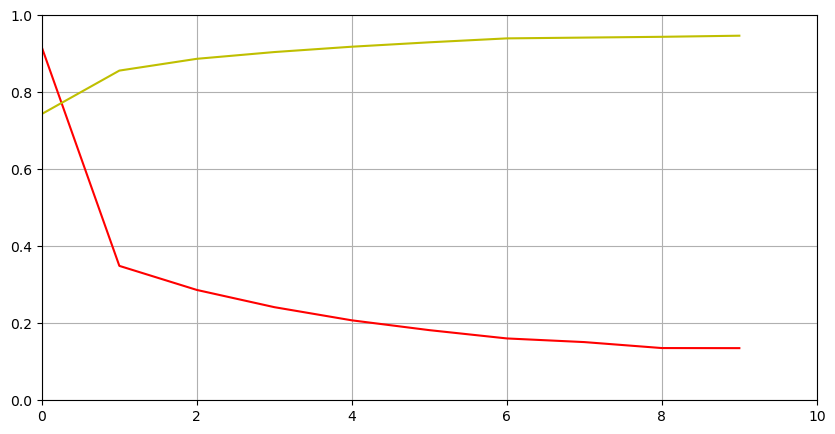

In [167]:
h=history_multi3.history
plt.figure(figsize=(10,5))
plt.plot(h['loss'], "r")
plt.plot(h['accuracy'], "y")
plt.grid(True)
plt.axis([0,10,0,1])

In [168]:
# Predict on the entire test dataset
all_predictions = []
all_labels = []

for images, labels in test_dataset:
    predictions = tl_mn.predict(images, verbose=0)
    all_predictions.append(predictions)
    all_labels.append(labels)

all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

predicted_classes = np.argmax(all_predictions, axis=1)

In [169]:
tl_mn_acc = 1 - np.sum(predicted_classes != all_labels)/len(test_labels)
print(f"Accuracy: {tl_mn_acc}")

Accuracy: 0.8664495114006514


In [170]:
tl_mn_cm = confusion_matrix(all_labels, predicted_classes)

In [171]:
tl_mn_pd_accs = perf_analysis.acc_for_class(tl_mn_cm, figure=True, colors=green_color)
tl_mn_pd_accs.loc[4] = tl_mn_acc
tl_mn_pd_accs = tl_mn_pd_accs.rename(index={4: "Accuracy"})
tl_mn_pd_accs

Classes          0
0         0.654930
1         0.888112
2         0.994624
Average   0.845888
Accuracy  0.866450

### Extract Explanations

Pred Index: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:18, 18.30s/it]               


Pred Index: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:17, 17.80s/it]               


Pred Index: 2


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:17, 17.81s/it]               


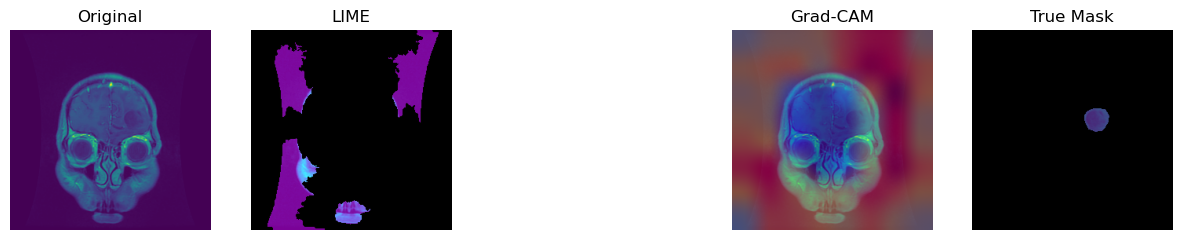

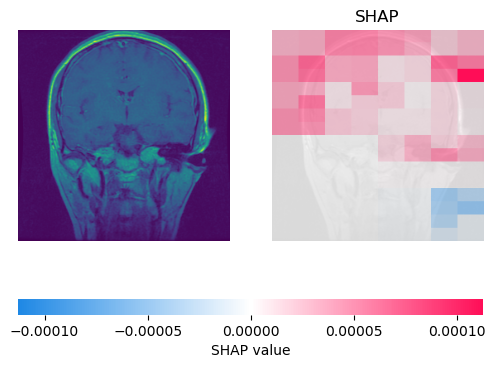

In [172]:
last_conv_layer_name = "Conv_1"

visual.brain_tumor(images_to_explain, true_masks, tl_mn, last_conv_layer_name, f"{logs_dir}\\mobilenet")

## Create CNN by Transfer Learning with RESNet50

In [173]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_shape)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(3, activation='softmax')(x) 

# Create the new model
tl_rn = models.Model(inputs=base_model.input, outputs=predictions)

In [174]:
optv4 = keras.optimizers.Nadam(learning_rate=0.005, beta_1=0.9,
beta_2=0.99)

tl_rn.compile(loss="sparse_categorical_crossentropy",
optimizer=optv4, metrics=["accuracy"])

In [175]:
tl_rn.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 24,638,339 (93.99 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [176]:
history_multi4 = tl_rn.fit(train_dataset, epochs=10)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.6518 - loss: 3.7242
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.8922 - loss: 0.2549
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9158 - loss: 0.2072
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.9331 - loss: 0.1760
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.9543 - loss: 0.1232
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.9405 - loss: 0.1513
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.9612 - loss: 0.1052
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.9480 - loss: 0.1184
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.9647 - loss: 0.1043
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.9527 - loss: 0.1230


In [177]:
h=history_multi4.history
plt.figure(figsize=(10,5))
plt.plot(h['loss'], "r")
plt.plot(h['accuracy'], "y")
plt.grid(True)
plt.axis([0,10,0,1])

(0.0, 10.0, 0.0, 1.0)

In [178]:
# Predict on the entire test dataset
all_predictions = []
all_labels = []

for images, labels in test_dataset:
    predictions = tl_rn.predict(images, verbose=0)
    all_predictions.append(predictions)
    all_labels.append(labels)

all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

predicted_classes = np.argmax(all_predictions, axis=1)

In [179]:
tl_rn_acc = 1 - np.sum(predicted_classes != all_labels)/len(test_labels)
print(f"Accuracy: {tl_rn_acc}")

Accuracy: 0.9039087947882736


In [180]:
tl_rn_cm = confusion_matrix(all_labels, predicted_classes)

In [181]:
tl_rn_pd_accs = perf_analysis.acc_for_class(tl_rn_cm, figure=True, colors=green_color)
tl_rn_pd_accs.loc[4] = tl_rn_acc
tl_rn_pd_accs = tl_rn_pd_accs.rename(index={4: "Accuracy"})
tl_rn_pd_accs

Classes          0
0         0.943662
1         0.835664
2         0.978495
Average   0.919274
Accuracy  0.903909

### Extract Explanations

Pred Index: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:43, 43.72s/it]               


Pred Index: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:39, 39.10s/it]               


Pred Index: 2


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:35, 35.07s/it]               


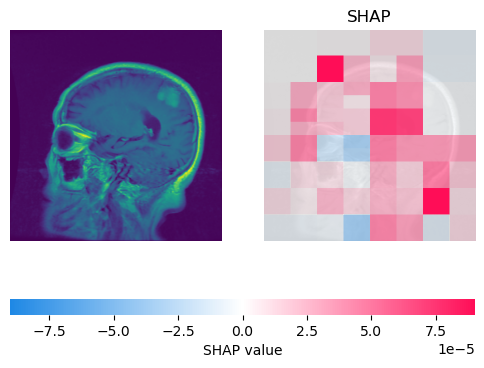

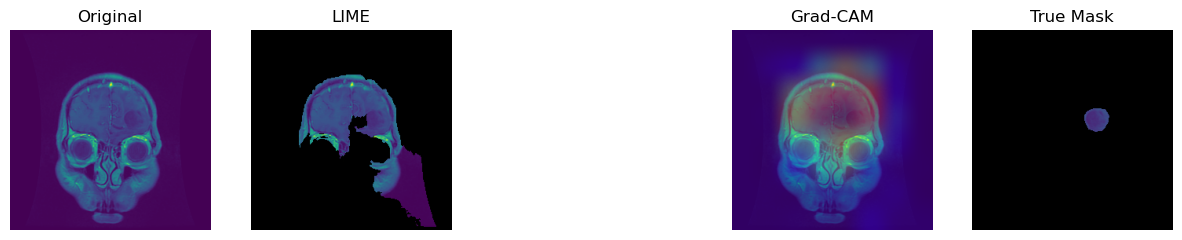

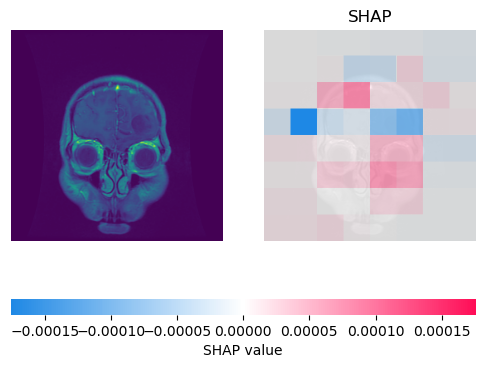

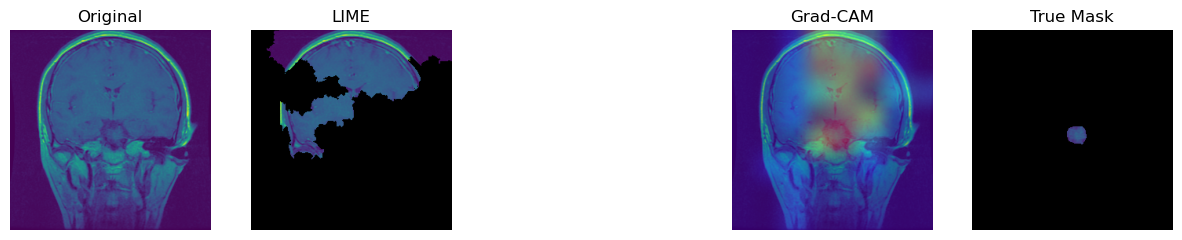

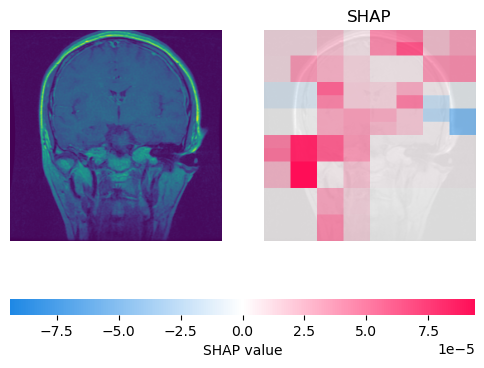

In [182]:
last_conv_layer_name = "conv5_block3_3_conv"

visual.brain_tumor(images_to_explain, true_masks, tl_rn, last_conv_layer_name, f"{logs_dir}\\resnet")

# Summary

## Metrics

In [183]:
cnn_raw_metrics = cnn_raw_pd_accs.rename(columns={0: "Raw CNN"})
cnn_raw_metrics["Raw CNN"] = [round(x, 2) for x in cnn_raw_metrics["Raw CNN"]]
tl_vgg_metrics = tl_vgg_pd_accs.rename(columns={0: "VGG"})
tl_vgg_metrics["VGG"] = [round(x, 2) for x in tl_vgg_metrics["VGG"]]
tl_mn_metrics = tl_mn_pd_accs.rename(columns={0: "MNet"})
tl_mn_metrics["MNet"] = [round(x, 2) for x in tl_mn_metrics["MNet"]]
tl_rn_metrics = tl_rn_pd_accs.rename(columns={0: "ResNet"})
tl_rn_metrics["ResNet"] = [round(x, 2) for x in tl_rn_metrics["ResNet"]]


overall_metrics = pd.concat([cnn_raw_metrics, tl_vgg_metrics, tl_mn_metrics, tl_rn_metrics], axis=1)
display(overall_metrics)

Classes   Raw CNN   VGG  MNet  ResNet
0            0.55  0.76  0.65    0.94
1            0.80  0.93  0.89    0.84
2            0.95  0.99  0.99    0.98
Average      0.77  0.89  0.85    0.92
Accuracy     0.79  0.91  0.87    0.90

In [184]:
latex_str = overall_metrics.columns.name  + ''.join([" & " + x for x in overall_metrics.columns]) + " \\\ \n"

In [185]:
for i, row in overall_metrics.iterrows():
    
    aux_str = str(i)
    for k in row:
        aux_str += f" & {k}"
    
    latex_str += aux_str + " \\\ \n"

with open(f"{logs_dir}/brain_tumor_metrics.txt", "w") as text_file:
    print(latex_str, file=text_file)

## Visual Accuracy per class

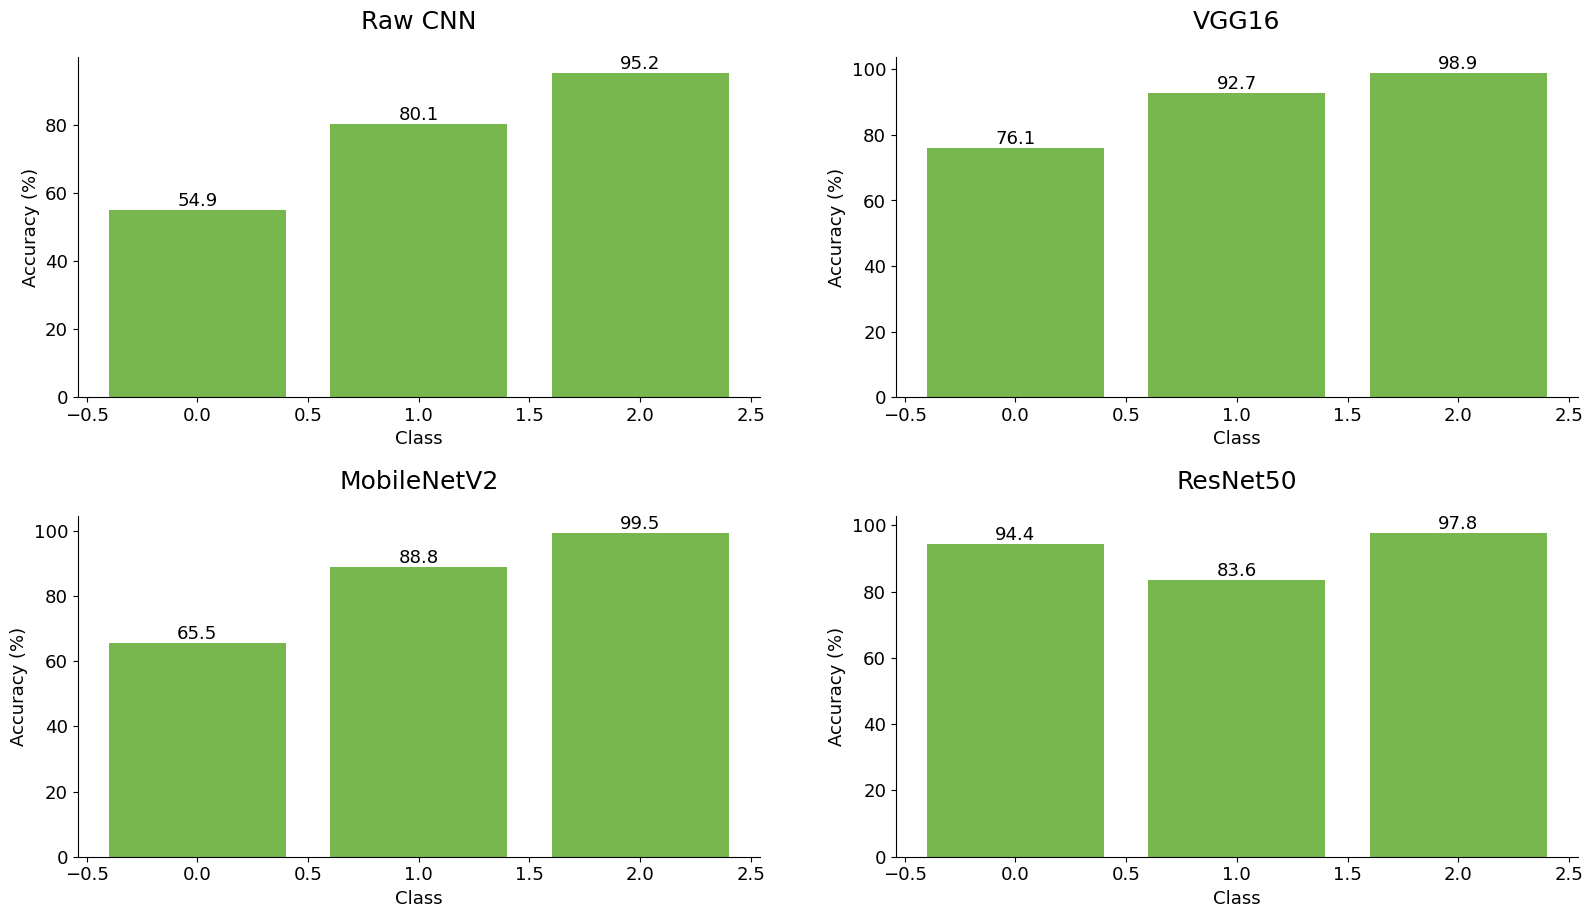

In [186]:
visual.acc_classes([cnn_raw_cm, tl_vgg_cm, tl_mn_cm, tl_rn_cm],
                  nrows=2, 
                  ncols=2, 
                  figsize=(15,8),
                  title_size=title_size,
                  label_size=label_size,
                  colors=[green_color, green_color, green_color, green_color],
                  titles=["Raw CNN", "VGG16", "MobileNetV2", "ResNet50"])

plt.savefig(f"{logs_dir}/brain_tumor_acc_classes.png", bbox_inches="tight")

plt.show()

## Confusion Matrices

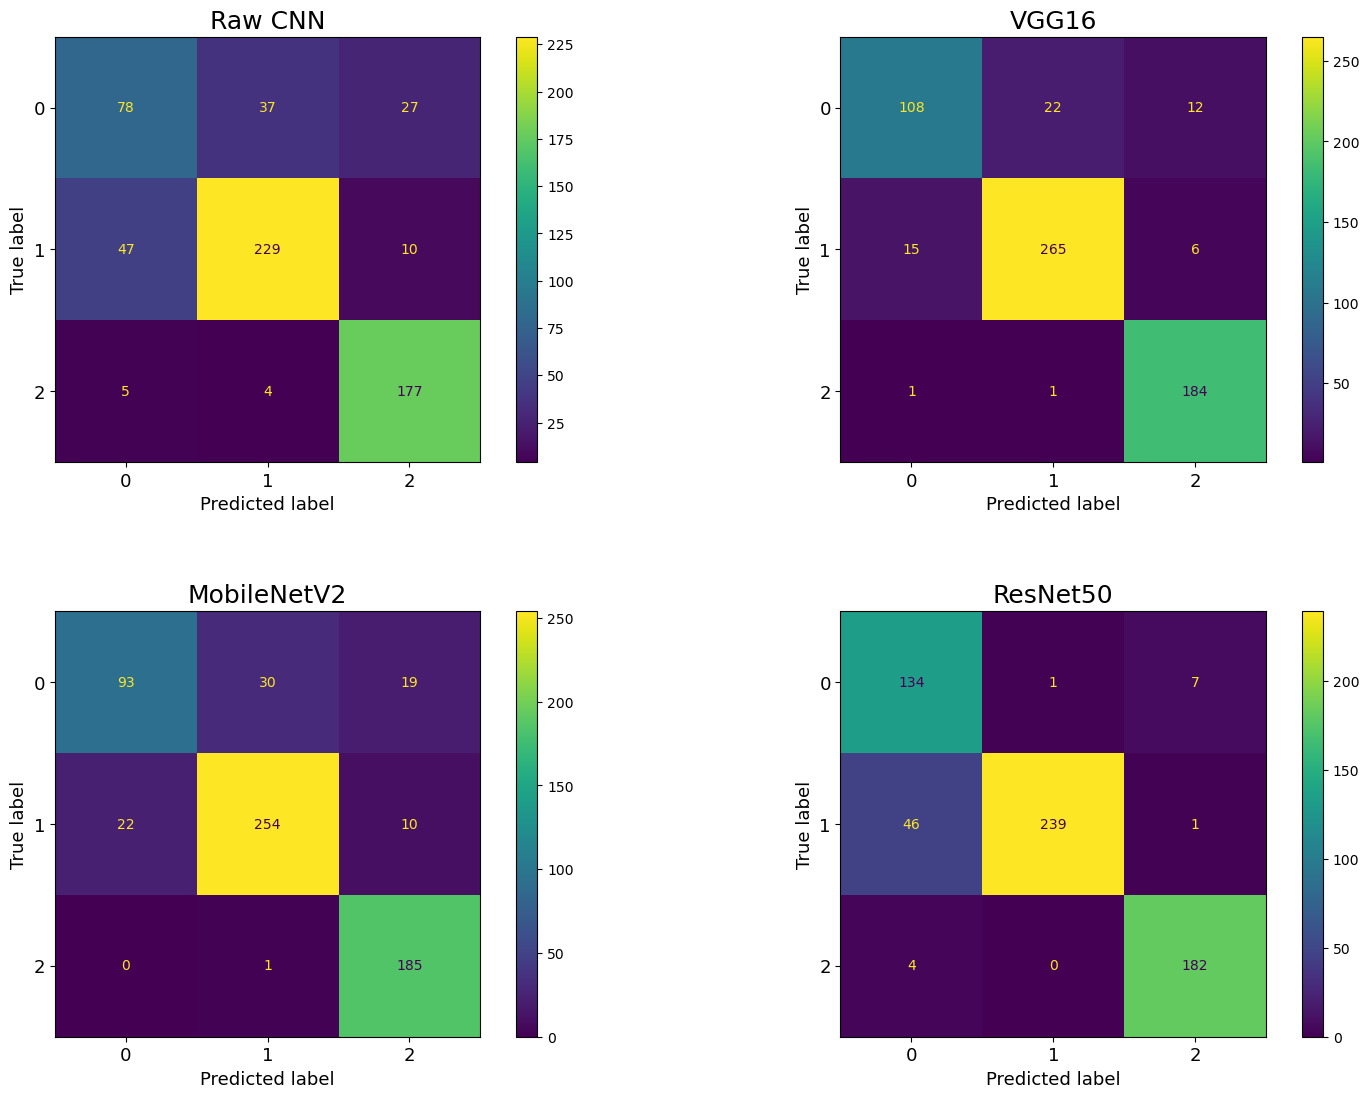

In [187]:
visual.confusion_matrices([cnn_raw_cm, tl_vgg_cm, tl_mn_cm, tl_rn_cm],
                          nrows=2, 
                          ncols=2, 
                          figsize=(15,10),
                          title_size=title_size,
                          label_size=label_size,
                          titles=["Raw CNN", "VGG16", "MobileNetV2", "ResNet50"]
                          )

plt.savefig(f"{logs_dir}/brain_tumor_conf_matrices.png", bbox_inches="tight")

plt.show()